> 1. DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.
> 2. SET THE "General Access" OF THE COPIED NOTEBOOK TO "Anyone with the link" BY CLICKING ON "Share" TO ENABLE SHARING WITH YOUR PEERS FOR REVIEW.


### This project is from the *Causal Inference for Data Science course on CoRise.* Learn more about the course [here](https://corise.com/course/causal-inference-for-data-science).



---





# Week 1 Project: Applying Linear Regression
***

Welcome to the first project for Causal Inference for Data Science!


## Scenario

Throughout this course, you will assume the role of a Data Scientist for Tongass, a retailer that sells goods online and in physical stores.

One day, a Tongass executive passes by your desk (or Zoom square) and asks, "Hey, you know things about data, right?"

"I like to think so," you reply as you lean back into your seat.

"Great... Because I've been thinking... How much of a benefit do we get from our physical stores anyway?"

"Benefit?" you ask.

"Like, if we can convince a customer to shop in person, does that boost their ultimate value to Tongass?"

"Hmmm," you say, "an interesting and important question. I'll look into it and report back!"

**This is the question we'll be interested in tackling — not only this week, but in weeks to come.**


## Project notes

### Data

We will work with a consistent data set througout this course (we introduce the data set more fully below). Not all parts of the data set will be applicable in any given week. The goal is demonstrating how a single set of granular data can be transformed to apply different causal inference techniques. We also hope to convey that manipulating data is in many ways the most important aspect of statistical modeling.

### Structure

We attempt to strike a balance between providing concrete steps to follow and making room for exploration. That said, we encourage you to explore: The best way to become a causal inference expert is to attack a single problem from multiple angles to see how different modeling choices affect an analysis. If this freedom is overwhelming, **don't panic**! You can simply fill out the code blocks marked "TODO" and ignore the optional ones. When we ask you to build models, we will provide the treatment effect you should expect so you can check your work.

In [2]:
# loading necessary packages
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns
sns.set()

import statsmodels.formula.api as smf

<br/>

## I. Load the data
***

We will work with a consistent data set throughout this course. The data set is in the file called `tongass_transactions.csv`.

Note: The data set is at the **transaction level**, not the customer level. Any given customer can (and likely does) have multiple transactions. Some measures and fields are at the customer level, while others are at the transaction level. It will be up to you to manipulate this data set so that it can be used for analysis. Note that the question we're interested in is fundamentally about *customers, not transactions,* which means we'll likely need to aggregate the data to the customer level to make it useful.

Below, we define the fields that are relevant for this week:
- `customer_id`: the unique identifier for a given customer
- `age`: the age of the customer
- `income`: the income of the customer 
- `state`: the customer's state of residence
- `distance`: the distance (in miles) from a customer's home to the nearest Tongass store
- `tx_order`: whether the transaction is the customer's first, second, third... etc.
- `amount`: the dollar value of the transaction
- `tx_date`: the date of the transaction
- `is_credit`: whether the transaction involved a credit card or a different payment method (1 if credit card, 0 if other)
- `in_store`: whether the transaction happened in a physical store (1 if yes, 0 if no and happened on tongass.com)

**NOTE**: If we don't mention a field above, then it won't be relevant for this week :)

In [4]:
# TODO: read in data (already filled out for you :)
url = 'https://raw.githubusercontent.com/dsaber/co-rise-causal-inference/main/tongass_transactions.csv'
df = pd.read_csv(url)
df.head(10)

,customer_id,age,income,state,received_re,received_in_store_re,distance,index,tx_order,amount,in_store,tx_date,is_credit,is_bonus
0,0,65,122753,ND,0,0,6.765402,0,0.0,61.964375,0.0,2020-12-31,0.0,0.0
1,0,65,122753,ND,0,0,6.765402,1,1.0,41.057234,0.0,2021-03-31,0.0,0.0
2,0,65,122753,ND,0,0,6.765402,2,2.0,71.752128,1.0,2021-06-30,1.0,0.0
3,0,65,122753,ND,0,0,6.765402,3,3.0,93.129942,1.0,2022-10-31,1.0,0.0
4,1,79,32977,DC,0,0,3.146723,0,0.0,61.334116,0.0,2020-01-31,0.0,0.0
5,1,79,32977,DC,0,0,3.146723,1,1.0,68.358069,1.0,2020-02-29,1.0,0.0
6,1,79,32977,DC,0,0,3.146723,2,2.0,111.872255,1.0,2020-03-31,1.0,0.0
7,1,79,32977,DC,0,0,3.146723,3,3.0,85.151689,1.0,2020-04-30,1.0,0.0
8,1,79,32977,DC,0,0,3.146723,4,4.0,57.457762,0.0,2020-07-31,0.0,0.0
9,1,79,32977,DC,0,0,3.146723,5,5.0,62.593378,0.0,2020-08-31,1.0,0.0


<br/>

## II. Familiarize yourself with the data set and determine if the causal question is worth investigating (spoiler: it will be)
***

Before we build any models, we should deeply understand the data set we're working with. 

In this section, you are free to do anything you would typically do when working with a new set of data; however, at a minimum, we recommend:
- Visualizing at least three key distributions (e.g., the number of transactions per customer, the dollar value of transactions/customers, etc.).
- Investigating whether the key causal question is worth investigating (e.g., by looking at whether customers who shop in store spend more money overall). One simple way to do this could be by looking at how customer value varies with the proportion of their transactions that occur in a physical store.
- Looking at which other variables might relate to customer value (e.g., age, income).

To get you started, we visualize a distribution below.

In [5]:
dfc = df.groupby('customer_id').agg({
    'tx_order': 'count',
    'amount': 'sum'
    }).rename(columns={'tx_order': 'num_transactions', 'amount': 'customer_value'}).reset_index()

In [6]:
dfc.head()

,customer_id,num_transactions,customer_value
0,0,4,267.903678
1,1,17,1604.529401
2,2,4,302.195168
3,3,7,511.422005
4,4,8,705.293409


In [7]:
print(dfc['customer_value'].max())
print(dfc['customer_value'].min())

3269.803562649664
21.800741761948984


[Text(0.5, 0, ''),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Number of customers with X transactions')]

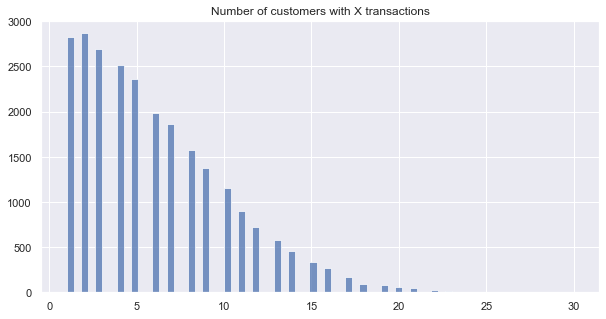

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.histplot(dfc['num_transactions'], ax=ax)
ax.set(
    xlabel='',
    ylabel='',
    title='Number of customers with X transactions'
)

Text(0.5, 1.0, 'Number of customers with X total value')

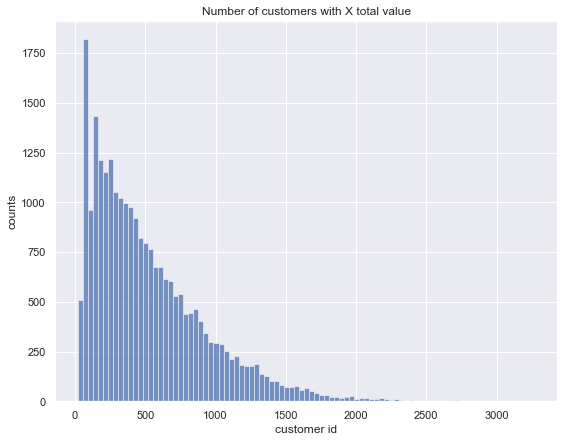

In [9]:
# TODO: visualize a key distribution (e.g., dollar value per customer, dollar value per customer cohort, etc.)

dollar_PC = df.groupby('customer_id')['amount'].sum().reset_index()

plt.figure(figsize=(9,7))
sns.histplot(dollar_PC['amount'])
plt.xlabel('customer id')
plt.ylabel('counts')
plt.title('Number of customers with X total value')


In [10]:
# TODO: determine if customer value seems correlated with in-store shopping
#To answer this question, I will take the average rate at which customer shop in store (the mean) and try plotting it against amount to see if there are any patterns


dfs = df.groupby('customer_id').agg({
    'in_store': 'mean',
    'amount': 'sum'  
}).reset_index()

dfs


,customer_id,in_store,amount
0,0,0.500000,267.903678
1,1,0.823529,1604.529401
2,2,0.750000,302.195168
3,3,0.428571,511.422005
4,4,0.500000,705.293409
...,...,...,...
24995,24995,1.000000,225.859608
24996,24996,0.500000,179.643234
24997,24997,0.857143,577.356105
24998,24998,0.200000,364.473408


Text(0, 0.5, 'amount')

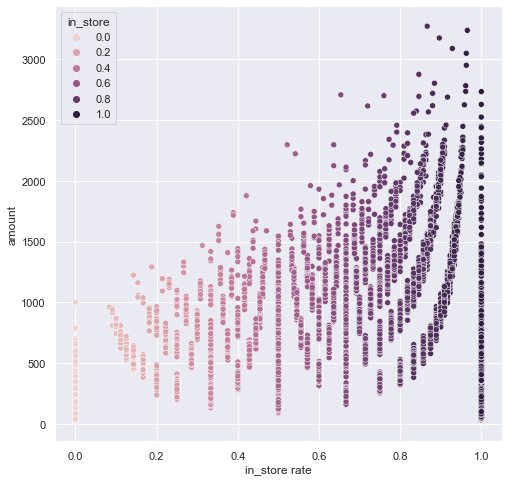

In [11]:

plt.figure(figsize=(8,8))
sns.scatterplot(x='in_store', y='amount', data=dfs, hue='in_store')
plt.xlabel('in_store rate')
plt.ylabel('amount')


I know the above plot looks like crap. But it does seems to me that those who shopped in store tend to have higher transactional value.

In [12]:
# TODO: determine if other variables (e.g., number of transactions, age, distance, etc.)
# seems correlated with in-store shopping

df_aggregated = df.groupby('customer_id').agg({
    'in_store': 'mean',
    'amount': 'sum',
    'tx_order': 'max',
    'income': 'mean',
    'age': 'mean',
    'distance': 'mean'
}).reset_index()

df_aggregated.head()


,customer_id,in_store,amount,tx_order,income,age,distance
0,0,0.500000,267.903678,3.0,122753.0,65.0,6.765402
1,1,0.823529,1604.529401,16.0,32977.0,79.0,3.146723
2,2,0.750000,302.195168,3.0,45734.0,23.0,1.578430
3,3,0.428571,511.422005,6.0,34358.0,46.0,5.121281
4,4,0.500000,705.293409,7.0,47111.0,24.0,7.128278


Text(0.5, 1.0, 'Correlation Heatmap')

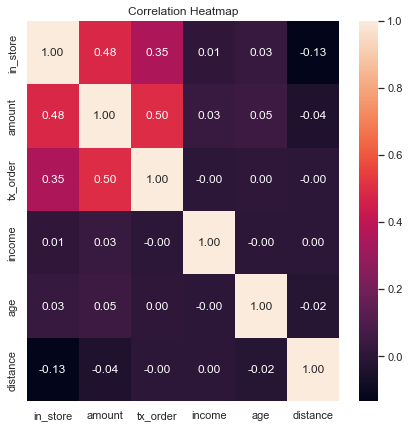

In [32]:
corr_mat = df[['in_store','amount','tx_order','income','age','distance']].corr()

plt.figure(figsize=(7,7))
sns.heatmap(corr_mat, annot=True, fmt='.2f')
plt.title('Correlation Heatmap')

Seems like **dollar value of the transaction**, **order of transactions** have some sort of a positive relationship with in store shopping while i don't see it for **age** and **distance** variables.

## III. Decide how you will approach the causal question of interest and manipulate the data accordingly
***

As you have likely noticed, our Tongass executive asked us a fairly high-level strategic question. They are broadly interested in the relationship between in-store shopping and customer value, but beyond that, they didn't provide additional structure.

In reality, you would have asked them additional follow-ups about how exactly this analysis would inform decision-making, but regardless, "translating" between vague high-level questions and the concrete act of preparing a statistical model is one of the main ways data scientists add value!

So let's do it.

### Approach 1

To start, let's think about the ways you could approach this problem. One simple way might be to say, "Well, we have a bunch of transactions data. We could simply aggregate it at the customer level and see whether customers who have a higher in-store shopping rate are more valuable."

In that case, the data would look something like this...

In [13]:
df_model1 = df.groupby('customer_id').agg({
    'in_store': 'mean', # the rate at which customer shops in store (treatment variable)
    'amount': 'sum', # the total amount a customer has spent (outcome variable)
    'tx_order': 'max', # a key control — the number of transactions this customer makes
    'distance': 'mean',
    'age': 'mean'
    # TODO: if you choose this approach, figure out how to construct the rest of the data set, 
    # including key variables like distance, age, etc.
}).reset_index()

print(df_model1.shape)

df_model1.head()

(25000, 6)


,customer_id,in_store,amount,tx_order,distance,age
0,0,0.500000,267.903678,3.0,6.765402,65.0
1,1,0.823529,1604.529401,16.0,3.146723,79.0
2,2,0.750000,302.195168,3.0,1.578430,23.0
3,3,0.428571,511.422005,6.0,5.121281,46.0
4,4,0.500000,705.293409,7.0,7.128278,24.0


Approaching the data this way would translate to the following causal problem: **"If we can boost the rate at which the typical customer shops in person, how does their long-run value change?"**

A couple of notes:
1. We're not preparing the data set for you completely — where would the fun be in that? ;)
2. Even in this formulation of the problem, there are still additional choices for us to make. For example, rather than looking at the "in-store shopping rate," we could look at whether a customer ever had *any* in-store transaction. Both decisions are reasonable, and both would communicate something slightly different. It's up to us to decide which concept is more meaningful given the data we have and the strategic decisions we wish to inform. (Don't worry about changing the above code to account for this note — this is mostly to point out there are many subtle ways we can construct data.)

### Approach 2

Alternatively, it could be more elegant (albeit complex) to reframe this problem as happening at a specific point in time to a specific population.

In particular, rather than looking at the data set as a whole, we could pick an arbitrary month and say, **"Hey, let's consider all the customers who only ever shopped online up till that point. The 'treatment' will then be shopping in person for the first time during that month of interest."**

The bones of this data manipulation would look something like this...

In [82]:
date_range = np.sort(df['tx_date'].unique())

intervention_month = date_range[len(date_range)//2]

df['tx_date'] < intervention_month

0          True
1          True
2          True
3         False
4          True
          ...  
151532     True
151533     True
151534     True
151535    False
151536    False
Name: tx_date, Length: 151537, dtype: bool

In [15]:
df_model2 = df.copy()
date_range = np.sort(df_model2['tx_date'].unique())

# arbitrarily take middle of date range as month of "intervention"
intervention_month = date_range[len(date_range)//2]

# get customers who had a transaction in month of "intervention"
customers = df_model2[df_model2['tx_date'] == intervention_month][['customer_id', 'in_store']]

df_model2['pre_intervention'] = df_model2['tx_date'] < intervention_month

df_model2 = df_model2.groupby(['customer_id', 'pre_intervention']).agg({
    'in_store': 'max',
    'amount': 'sum',
    'tx_order': 'max', # count number of transactions for this customer
    'distance': 'mean',
    'age': 'mean',
    'income':'mean'
    # TODO: if you choose this approach, figure out how to construct the rest of the data set, 
    # including key variables like distance, age, etc.
}).reset_index()

In [16]:
# filter to customers who only shopped online before "intervention"
df_model2_pre = df_model2[(df_model2['pre_intervention'] == True) & (df_model2['in_store'] == 0)].drop(columns=['amount', 'in_store'])

# join on relevant customer population and get "treatment" — whether they
# shopped in store or online during relevant month
df_model2_pre = pd.merge(df_model2_pre, customers, on='customer_id', how='inner')

# get outcome for above customers
df_model2_post = df_model2[df_model2['pre_intervention'] == False][['customer_id', 'amount']]

# combine these data sets
df_model2_final = pd.merge(df_model2_pre, df_model2_post, how='left', on='customer_id').fillna(0)

print(df_model2_final.shape)
df_model2_final.head()

(698, 8)


,customer_id,pre_intervention,tx_order,distance,age,income,in_store,amount
0,64,True,1.0,0.951614,33.0,25834.0,1.0,233.056367
1,67,True,0.0,2.200955,18.0,145669.0,1.0,263.104737
2,84,True,1.0,9.920939,48.0,102891.0,1.0,271.067656
3,95,True,3.0,13.419045,76.0,166848.0,1.0,218.513530
4,139,True,0.0,4.207547,59.0,248993.0,1.0,148.357707


The code is much more complicated, but it elegantly maps to the following causal question: **"If we convince a purely online shopper to buy something in a store, how much extra value does that generate in the long-run?"**

That's an interesting (and actionable!) question, so it could be worth the data munging pain. Whether you agree is up to you ;)

Also note that this approach _does_ involve throwing out a lot of data. In a future version of this analysis, it might be worth thinking about whether there are ways to structure the problem so that we throw out less, or, if you go down this path, to consider repeating this analysis for different months to see if the result is robust.

**NOTE**: If this framing of the problem seems at all confusing, don't worry! Just go with Approach 1.

### Note on Step III

There's a reason we're spending a lot of time on this section. It might seem silly, but this is often the most complex part of any modeling problem. Once you have your data in place, fitting models and deciding which works best is often a more straightforward task! (as you'll hopefully soon see :)

## IV. Fit a simple (!) baseline model
***

Woohoo! We can finally start modeling.

Fit the simplest possible model you can using `statsmodels` (we recommend a call to [`smf.ols`](https://www.statsmodels.org/stable/example_formulas.html) like we used in the written material). The model should be your outcome regressed against your treatment (and that's it!).

You should see an extremely strong and statistically significant effect. But, of course, a lot of that is simply selection bias, as we'll see.

In [17]:
df_model2_final.columns

Index(['customer_id', 'pre_intervention', 'tx_order', 'distance', 'age',
       'income', 'in_store', 'amount'],
      dtype='object')

In [18]:
df_model2_final.head()

,customer_id,pre_intervention,tx_order,distance,age,income,in_store,amount
0,64,True,1.0,0.951614,33.0,25834.0,1.0,233.056367
1,67,True,0.0,2.200955,18.0,145669.0,1.0,263.104737
2,84,True,1.0,9.920939,48.0,102891.0,1.0,271.067656
3,95,True,3.0,13.419045,76.0,166848.0,1.0,218.513530
4,139,True,0.0,4.207547,59.0,248993.0,1.0,148.357707


In [19]:
# TODO: fit a simple model — just outcome on one side and treatment on the other
# CHECK: if you go with Approach 1, your treatment effect should be ~495; if you go with Approach 2,
# your treatment effect should be ~38

base_model = smf.ols(formula = 'amount ~ in_store', data=df_model2_final)
base_model_results = base_model.fit()
print("Just regressing amount on in_store")
base_model_results.summary()

Just regressing amount on in_store


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     8.255
Date:                Mon, 12 Jun 2023   Prob (F-statistic):            0.00419
Time:                        15:49:25   Log-Likelihood:                -4588.2
No. Observations:                 698   AIC:                             9180.
Df Residuals:                     696   BIC:                             9189.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    283.8894      9.533     29.780      0.000     265.173     302.606
in_store      37.7721     13.147      2.873      0.004      11.960      63.584
==============================================================================
Omnibus:                      111.400   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.690
Skew:                           1.015   Prob(JB):                     5.80e-40
Kurtosis:                       4.445   Cond. No.                         2.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Just a gentle reminder to myself that adjusted R square stands at **10%** here.

## V. Address omitted variable bias (OVB) by interrogating residuals and fitting more complicated models
***

Now that we have a baseline model, we can improve it. This is usually an iterative process.

One useful way to get a handle on OVB is by investigating the residuals in our models. In a "complete" model, it should be hard to find patterns in our residuals. They should look like random noise regardless of which missing variables we plot them against. In an "incomplete" model, finding patterns in our residuals should be easier.

So let's try it.

Plot the residuals of your simple model against key missing explanatory variables (e.g., age, the number of transactions a customer has, etc.). If you see strong patterns, then it suggests we haven't yet achieved conditional independence. Add important variables to your simple model and "build up" to a more complete one, paying special attention to how our effect size and R-squared change over time (the former should eventually stabilize and the latter should increase).

If you haven't come across seaborn's `lmplot` function before, it might be helpful here: https://seaborn.pydata.org/generated/seaborn.lmplot.html

In [21]:
# TODO: plot residuals from simple model against a key missing variable (e.g., age,
# income, number of transactions, etc.)

#Copying into a new dataframe first for Residual analysis
df_model2_final_RA = df_model2_final.copy()
#Extracting the residuals from the baseline fit model
df_model2_final_RA['Residuals'] = base_model_results.resid


<Figure size 576x576 with 0 Axes>

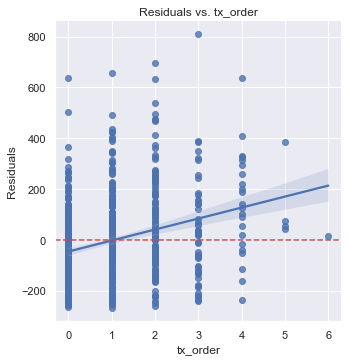

In [25]:
# Create a plot of residuals as a function of tx_order
plt.figure(figsize=(8, 8))

sns.lmplot(x='tx_order', y='Residuals', data=df_model2_final_RA)
plt.ylabel('Residuals')
plt.title('Residuals vs. tx_order')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

<Figure size 576x432 with 0 Axes>

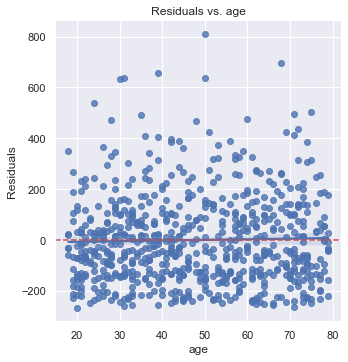

In [26]:
# Create a plot of residuals as a function of age
plt.figure(figsize=(8, 6))
sns.lmplot(x='age', y='Residuals', data=df_model2_final_RA)
plt.ylabel('Residuals')
plt.title('Residuals vs. age')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

<Figure size 800x600 with 0 Axes>

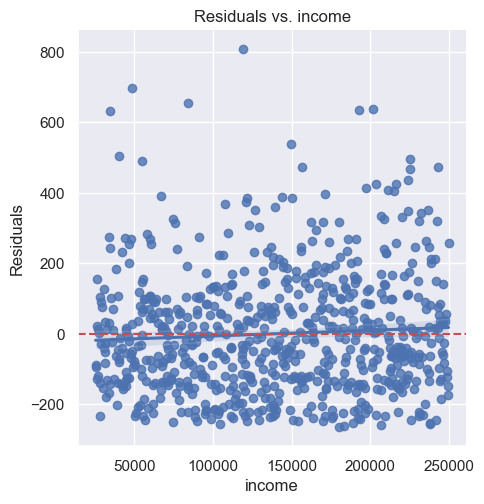

In [97]:
# Create a plot of residuals as a function of income
plt.figure(figsize=(8, 6))
sns.lmplot(x='income', y='Residuals', data=df_model2_final_RA)
plt.ylabel('Residuals')
plt.title('Residuals vs. income')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

<Figure size 576x432 with 0 Axes>

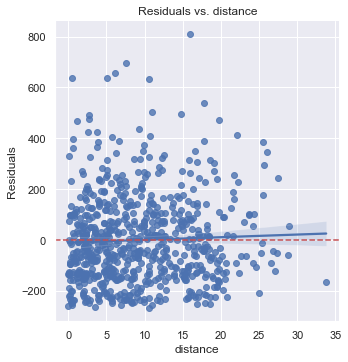

In [27]:
# Create a plot of residuals as a function of distance
plt.figure(figsize=(8, 6))
sns.lmplot(x='distance', y='Residuals', data=df_model2_final_RA)
plt.ylabel('Residuals')
plt.title('Residuals vs. distance')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Based on the residual diagnostic plots which I have created, there appears to be some sort of a positive relationship between the transaction order and the model residuals. It does seems that the regression model systematically underestimate the monetary value of the higher order.

In [29]:
# TODO: fit another regression that incorporates this missing variable
model2 = smf.ols(formula = 'amount ~ in_store + tx_order', data=df_model2_final)
model2_results = model2.fit()
print("Regressing amount on in_store + tx_order")
model2_results.summary()

Regressing amount on in_store + tx_order


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     34.36
Date:                Mon, 12 Jun 2023   Prob (F-statistic):           5.90e-15
Time:                        15:53:06   Log-Likelihood:                -4559.4
No. Observations:                 698   AIC:                             9125.
Df Residuals:                     695   BIC:                             9138.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    240.5253     10.736     22.403      0.000     219.446     261.604
in_store      34.6042     12.631      2.740      0.006       9.805      59.404
tx_order      43.2334      5.592      7.731      0.000      32.253      54.214
==============================================================================
Omnibus:                       96.741   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.070
Skew:                           0.914   Prob(JB):                     1.57e-33
Kurtosis:                       4.361   Cond. No.                         4.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I noted that the treatment effect of **in_store[T.True]** only dropped marginally from ~38 to ~35 while adjusted R square actually declined from ~ 10% to ~8.7%. **tx_order** variable is still statistically significant at 95% confidence level and we observe a positive relationship between tx_order and amount which made sense.

Let me try with potential confounders like **income** etc just to see the outcome.

In [30]:
model3 = smf.ols(formula = 'amount ~ in_store + income', data=df_model2_final)
model3_results = model3.fit()
print("Regressing amount on in_store + income")
model3_results.summary()

Regressing amount on in_store + income


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     5.394
Date:                Mon, 12 Jun 2023   Prob (F-statistic):            0.00474
Time:                        15:53:11   Log-Likelihood:                -4586.9
No. Observations:                 698   AIC:                             9180.
Df Residuals:                     695   BIC:                             9193.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    261.4144     17.076     15.309      0.000     227.888     294.941
in_store      37.5778     13.133      2.861      0.004      11.793      63.363
income         0.0002      0.000      1.586      0.113   -3.85e-05       0.000
==============================================================================
Omnibus:                      111.530   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.080
Skew:                           1.009   Prob(JB):                     1.76e-40
Kurtosis:                       4.491   Cond. No.                     4.31e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The inclusion of the **income** variables to regression does not add any value. The variable itself is statistically insignificant and we also observe that the treatment effect from **in_store[T.True]** remained almost similar at ~37. From this result above, I am pretty sure that any OVB *if there is* certaintly cannot be attributed to **income**.

In [31]:
df_model2_final.head()

,customer_id,pre_intervention,tx_order,distance,age,income,in_store,amount
0,64,True,1.0,0.951614,33.0,25834.0,1.0,233.056367
1,67,True,0.0,2.200955,18.0,145669.0,1.0,263.104737
2,84,True,1.0,9.920939,48.0,102891.0,1.0,271.067656
3,95,True,3.0,13.419045,76.0,166848.0,1.0,218.513530
4,139,True,0.0,4.207547,59.0,248993.0,1.0,148.357707


In [32]:
full_model = smf.ols(formula = 'amount ~ in_store + income + age + distance + tx_order', data=df_model2_final)
full_model_results = full_model.fit()
print("Full Long model")
full_model_results.summary()

Full Long model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     14.36
Date:                Mon, 12 Jun 2023   Prob (F-statistic):           2.15e-13
Time:                        15:53:29   Log-Likelihood:                -4557.8
No. Observations:                 698   AIC:                             9128.
Df Residuals:                     692   BIC:                             9155.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    209.6869     25.622      8.184      0.000     159.382     259.992
in_store      34.3451     13.046      2.633      0.009       8.730      59.960
income         0.0002   9.81e-05      1.683      0.093   -2.75e-05       0.000
age            0.1528      0.357      0.428      0.669      -0.549       0.855
distance       0.0809      0.988      0.082      0.935      -1.859       2.021
tx_order      43.1621      5.645      7.647      0.000      32.080      54.245
==============================================================================
Omnibus:                       97.027   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.036
Skew:                           0.904   Prob(JB):                     2.16e-34
Kurtosis:                       4.436   Cond. No.                     6.34e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the full long model results shown above, it appears that only **in_store[T.True]** (treatment variable) and **tx_order** (control variable) are statistically significant. As such, it doesn't make sense to include the other variables like **income**, **age**, **distance**.

For now, I would settle for model2 - which include **in_store[T.True]** & **tx_order**  - where *estimated* treatment effect is ~35

In [14]:
# TODO: repeat above steps for additional variables (e.g., plot residuals from more complex model against
# key missing variables). build up to a more complicated and complete model in an iterative way

# CHECK: Depending on how many controls you include in your final model, your estimated treatment effect
# for Approach 1 should be ~46, and your estimated treatment effect for Approach 2 should be ~37. That said,
# there is room for variation here depending on the controls you ultimately decide to include

## VI. Compare baseline model with more complicated models and "pick" your favorite
***

At this point, it's useful hygiene to take a step back and look at your models in a more systematic way.

In particular, you might consider the following questions as you review the regression output above:
- Which variables are your biggest confounders? Which are useful controls but aren't true confounders (i.e., they don't much change your estimate for the treatment effect)?
- Has your treatment effect "stabilized" across models, even as you've made them more complex?
- Has your treatment effect remained significant, both in statistical and practical terms?
- Has the R-squared increased? Or is there still a lot of unexplained variation? Could that unexplained variation plausibly be due to randomness, or are we likely missing important confounding variables? (If we're likely missing important confounding variables, then we should be careful in how we communicate the results. We might consider them preliminary rather than definitive.)

In [33]:
# compare models and pick our favorite (remember Einstein's maxim: "everything 
# should be made as simple as possible, but no simpler")

# TODO: output the regression summary of the model you ultimately selected

model2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     34.36
Date:                Mon, 12 Jun 2023   Prob (F-statistic):           5.90e-15
Time:                        15:54:21   Log-Likelihood:                -4559.4
No. Observations:                 698   AIC:                             9125.
Df Residuals:                     695   BIC:                             9138.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    240.5253     10.736     22.403      0.000     219.446     261.604
in_store      34.6042     12.631      2.740      0.006       9.805      59.404
tx_order      43.2334      5.592      7.731      0.000      32.253      54.214
==============================================================================
Omnibus:                       96.741   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.070
Skew:                           0.914   Prob(JB):                     1.57e-33
Kurtosis:                       4.361   Cond. No.                         4.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## VII. Consolidate the analysis you performed above so it's useful for a stakeholder
***

### Congratulations!

You've done a ton of incredible work. Now, it's time to package it all together so our Tongass executive can follow along.

This step often feels like doing an analysis "in reverse." We don't want to step someone through all the logic we just went through to arrive at our answer (as tempting as that might be). We want to share our answer **first,** then help our stakeholders understand it intuitively by sharing visuals and explaining how confident we can be.

Here is a set of suggested steps, but feel free to tweak as you see fit:
- Share the results from your final model, making sure to put the results in **business terms** (e.g., "getting an online customer to shop in store boosts the value of our customer base by X; if we can convince 100 online customers to shop in person, we can expect between Y and Z in additional lifetime value")
- Show key visuals to help someone grok the relationship intuitively
- Comment on our degree of confidence of results, both in quantitative terms (e.g., confidence interval) and qualitative terms (e.g., "model seems robust/sensitive to controls, which means we can be confident/should consider this a preliminary hypothesis warranting deeper experimentation")

### Executive Summary
Based on the results shown above, if we do manage to convince an online shopper to buy something in the store, this will result in an additional **~ +35** dollars in transaction value to the company, all else being constant.

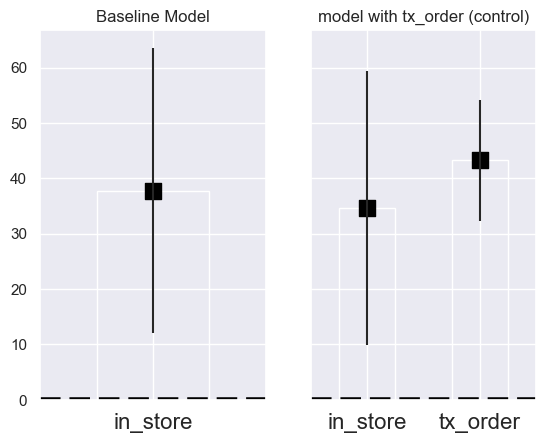

In [185]:
err_series = base_model_results.params - base_model_results.conf_int()[0]
model2_err_series = model2_results.params - model2_results.conf_int()[0]

basemodel_coef_df = pd.DataFrame({'coef': base_model_results.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })

model2_coef_df = pd.DataFrame({'coef': model2_results.params.values[1:],
                               'err': model2_err_series.values[1:],
                               'varname': model2_err_series.index.values[1:]})


fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
basemodel_coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax1, color='None', 
             yerr='err', legend=False)
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_title('Baseline Model')
ax1.scatter(x=pd.np.arange(basemodel_coef_df.shape[0]), 
           marker='s', s=120, 
           y=basemodel_coef_df['coef'], color='black')
ax1.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax1.xaxis.set_ticks_position('none')
_ = ax1.set_xticklabels(['in_store'], 
                       rotation=0, fontsize=16)

model2_coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax2, color='None', 
             yerr='err', legend=False)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_title('model with tx_order (control)')
ax2.scatter(x=pd.np.arange(model2_coef_df.shape[0]), 
           marker='s', s=120, 
           y=model2_coef_df['coef'], color='black')
ax2.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax2.xaxis.set_ticks_position('none')
_ = ax2.set_xticklabels(['in_store','tx_order'], 
                       rotation=0, fontsize=16)

If we looked at the regression coefficients plot above, we can see on average that getting an online customer to **shop in store** would be **~ 38 dollars** in transactional value. But if we do include tx_order as an additional control variable, this slightly reduces the treatment effect to **~ 35**.

In [17]:
# TODO: output a key visual (either from above or a new one) that you think communicates
# your results in a statistically responsible way (tip: it can sometimes be worth
# visualizing how the "average" treated customer differs from the
# "average" untreated customer)

In [18]:
# TODO: change this cell to a markdown cell and write a blurb on how confident you
# are in your results and why

## VIII. OPTIONAL: Consider additional analysis steps
***
1. We would highly recommend tackling this problem in multiple ways to see how it changes your analysis. For example, if you used the first approach for transforming data, maybe considering trying the second. Think about which question each approach answers, and which is more actionable in a business context. Try others we might not have considered. 
2. In the written material for Week 1, we considered the "OVB equation," which allows us to quantify OVB in "short" models by connecting them to "long" models. We didn't explicitly leverage the OVB equation in this project, but we implicitly did. That said, it could be worth leveraging it directly so you can become more comfortable applying it and thinking about OVB intuitively. Consider quantifying the OVB that results from leaving out "age" in your simple model.
3. We didn't cover log transformations in Week 1, but they can sometimes be helpful if we want to analyze causal relationships in percentage terms. Read [this](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/) and consider changing your analysis approach accordingly to answer our causal question somewhat differently.
4. In the material above, we made sure to control for a customer's number of transactions. The idea here is defensible: We want to compare "similar" customers and highlight the differences that arise purely because of their decision to shop online v. in-store. BUT! What if shopping in-person actually *encourages* customers to shop more frequently? It could be a key mechanism by which in-store shopping works to increase a given customer's value. That would make a customer's number of transactions a **bad control.** Consider investigating this issue by diving deep on whether in-store shopping *leads* to more transactions, and how big an issue this actually is for analysis.

## IX. EXTREMELY OPTIONAL: Tackle another problem
***

When it comes to learning causal inference, there is no substitute for practice. We would strongly support finding data sets in the wild (e.g. [here](https://docs.google.com/spreadsheets/d/1wZhPLMCHKJvwOkP4juclhjFgqIY8fQFMemwKL2c64vk/edit#gid=0), [here](https://ourworldindata.org/), or [here](https://github.com/awesomedata/awesome-public-datasets)) and using the same general framework we leveraged here toward a causal question you're interested in.